<a href="https://colab.research.google.com/github/SJinLee/PPG/blob/main/02.find_peak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://www.kaggle.com/datasets/canaria/5-gamers
* https://www.kaggle.com/code/rfinean/fatigue-data-exploration

In [2]:
!unzip -d input drive/MyDrive/ppg/archive.zip

Archive:  drive/MyDrive/ppg/archive.zip
replace input/gamer1-annotations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: input/gamer1-annotations.csv  
replace input/gamer1-ppg-2000-01-01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: input/gamer1-ppg-2000-01-01.csv  
  inflating: input/gamer1-ppg-2000-01-02.csv  
  inflating: input/gamer2-annotations.csv  
  inflating: input/gamer2-ppg-2000-01-01.csv  
  inflating: input/gamer2-ppg-2000-01-02.csv  
  inflating: input/gamer3-annotations.csv  
  inflating: input/gamer3-ppg-2000-01-01.csv  
  inflating: input/gamer3-ppg-2000-01-02.csv  
  inflating: input/gamer4-annotations.csv  
  inflating: input/gamer4-ppg-2000-01-01.csv  
  inflating: input/gamer4-ppg-2000-01-02.csv  
  inflating: input/gamer5-annotations.csv  
  inflating: input/gamer5-ppg-2000-01-01.csv  
  inflating: input/gamer5-ppg-2000-01-02.csv  


In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
os.listdir('./input/')

['gamer1-annotations.csv',
 'gamer5-ppg-2000-01-02.csv',
 'gamer4-ppg-2000-01-02.csv',
 'gamer3-ppg-2000-01-01.csv',
 'gamer4-annotations.csv',
 'gamer5-ppg-2000-01-01.csv',
 'gamer5-annotations.csv',
 'gamer2-ppg-2000-01-01.csv',
 'gamer3-ppg-2000-01-02.csv',
 'gamer1-ppg-2000-01-02.csv',
 'gamer1-ppg-2000-01-01.csv',
 'gamer2-ppg-2000-01-02.csv',
 'gamer4-ppg-2000-01-01.csv',
 'gamer3-annotations.csv',
 'gamer2-annotations.csv']

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [8]:
gamerID = 'gamer5'

In [9]:
dateCols = ['Datetime']
anots = pd.read_csv('./input/' + gamerID + '-annotations.csv', parse_dates=dateCols)
anots.dataframeName = gamerID + '-annotations'
anots.shape

(86, 3)

In [10]:
anots.head(30)

,Datetime,Event,Value
0,2000-01-01 11:00:00,Stanford Sleepiness Self-Assessment (1-7),3
1,2000-01-01 12:00:00,Stanford Sleepiness Self-Assessment (1-7),1
2,2000-01-01 13:00:00,Stanford Sleepiness Self-Assessment (1-7),1
3,2000-01-01 14:00:00,Stanford Sleepiness Self-Assessment (1-7),1
4,2000-01-01 15:00:00,Stanford Sleepiness Self-Assessment (1-7),3
5,2000-01-01 16:00:00,Stanford Sleepiness Self-Assessment (1-7),2
6,2000-01-01 17:00:00,Stanford Sleepiness Self-Assessment (1-7),1
7,2000-01-01 18:00:00,Stanford Sleepiness Self-Assessment (1-7),2
8,2000-01-01 19:00:00,Stanford Sleepiness Self-Assessment (1-7),1
9,2000-01-01 20:00:00,Stanford Sleepiness Self-Assessment (1-7),1


In [11]:
anots['Event'].value_counts()

Stanford Sleepiness Self-Assessment (1-7)    25
Diary Entry (text)                           24
Sleep-2-Peak Reaction Time (ms)              23
Name: Event, dtype: int64

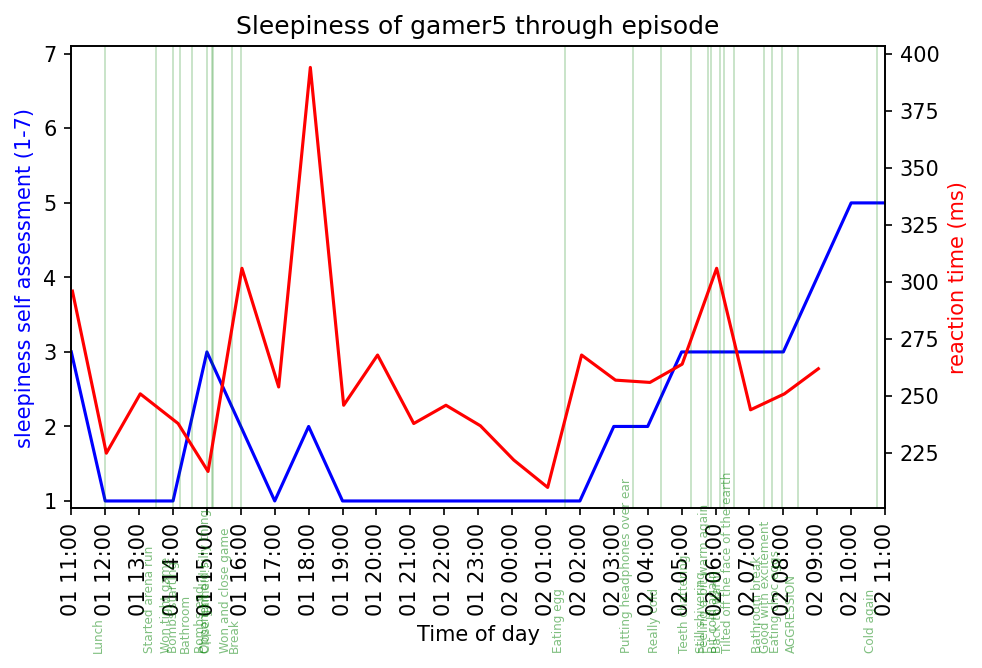

In [12]:
import matplotlib as mpl
sss = anots[anots.Event == "Stanford Sleepiness Self-Assessment (1-7)"].drop('Event', axis=1).copy()
sss['SelfAssess'] = sss['Value'].map(lambda x: float(x))

rt = anots[anots.Event == "Sleep-2-Peak Reaction Time (ms)"].drop('Event', axis=1).copy()
rt['ReactTime'] = rt['Value'].map(lambda x: float(x))

diary = anots[anots.Event == "Diary Entry (text)"].drop('Event', axis=1).copy()

fatigueplot = plt.figure(figsize=(7,4), dpi= 150)
axsa = fatigueplot.add_subplot(1,1,1)
axsa.set_title('Sleepiness of ' + gamerID + ' through episode')
axsa.set_xlabel('Time of day')
plt.xticks(rotation=90)
axsa.set_xlim(pd.Timestamp('2000-01-01 11:00'), pd.Timestamp('2000-01-02 11:00:00'))
axsa.xaxis.set_major_locator(mpl.dates.HourLocator()) # .MinuteLocator
axsa.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %H:%M'))
#axsa.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%H:%M'))
axsa.set_ylabel('sleepiness self assessment (1-7)', color='b')
axsa.set_ylim(0.9,7.1)
axrt = axsa.twinx()
axrt.set_ylabel('reaction time (ms)', color='r')

axsa.plot('Datetime', 'SelfAssess', 'b-', data=sss)
axrt.plot('Datetime', 'ReactTime', 'r-', data=rt)

for item in diary.iterrows():
    s = item[1]
    axsa.axvline(s.Datetime, linewidth=0.2, color='g')
    axsa.text(s.Datetime, -1.0, s.Value, rotation=90, fontsize='xx-small',
              color='g', alpha=0.5, horizontalalignment='right')

#fatigueplot.autofmt_xdate()
plt.show()

In [14]:
nRowsRead = 2000 # specify 'None' if want to read whole file
# gamer1-ppg-2000-01-01.csv has 2,996,500 rows (about 12hrs) in reality
# but we are only previewing the first 2000 rows
ppg = pd.read_csv('./input/' + gamerID + '-ppg-2000-01-01.csv', delimiter=',', nrows = nRowsRead)
ppg.dataframeName = gamerID + '-ppg-2000-01-01.csv'
ppg.shape

(2000, 2)

In [15]:
ppg.head(10)

,Time,Red_Signal
0,12:54:44.096662,686
1,12:54:44.100672,656
2,12:54:44.100672,526
3,12:54:44.101674,422
4,12:54:44.102676,327
5,12:54:44.105684,251
6,12:54:44.106687,192
7,12:54:44.106687,147
8,12:54:44.107690,113
9,12:54:44.108702,87


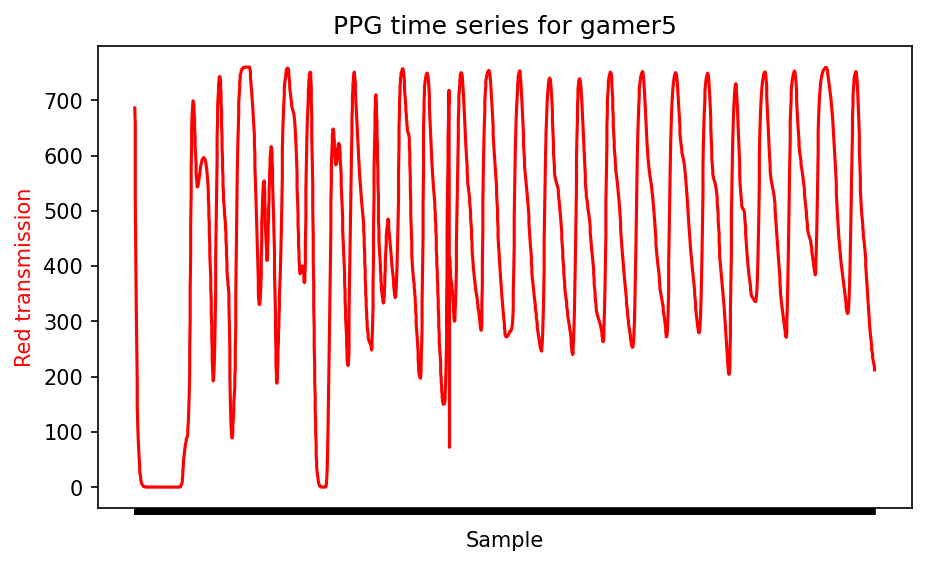

In [16]:
ts = plt.figure(figsize=(7,4), dpi= 150)
ax = ts.add_subplot(1,1,1)
ax.set_title('PPG time series for ' + gamerID)
ax.set_xlabel('Sample')
ax.set_xticklabels([])
ax.set_ylabel('Red transmission', color='r')
ax.plot('Time', 'Red_Signal', 'r-', data=ppg)
ts.show()

In [17]:
ppg['timestamp'] = pd.to_datetime(ppg['Time'])

ppg.head()

,Time,Red_Signal,timestamp
0,12:54:44.096662,686,2024-02-02 12:54:44.096662
1,12:54:44.100672,656,2024-02-02 12:54:44.100672
2,12:54:44.100672,526,2024-02-02 12:54:44.100672
3,12:54:44.101674,422,2024-02-02 12:54:44.101674
4,12:54:44.102676,327,2024-02-02 12:54:44.102676


In [18]:
def compare_t_axes(data_range):
    """
    plots time series as a resampled series above the time-stamped version

    Parameters
    ----------
    data_range : pandas.dataframe
        Pandas dataframe with columns 'Red_signal' for y-axis and 'timestamp' for x-axis
    """
    ts, (ax, tsax) = plt.subplots(2, figsize=(7,4), dpi= 150)
    ts.suptitle('PPG time series')
    ax.set_title('at constant sample rate:')
    ax.set_ylabel('Red tx', color='r')
    ax.xaxis.set_visible(False)
    ax.plot('Time', 'Red_Signal', 'r-', data=data_range)

    tsax.set_title('and using timestamps:')
    tsax.set_xlabel('Timestamp Time')
    plt.xticks(rotation = 90)
    tsax.set_ylabel('Red tx', color='r')
    tsax.plot('timestamp', 'Red_Signal', 'r-', data=data_range)
    ts.show()

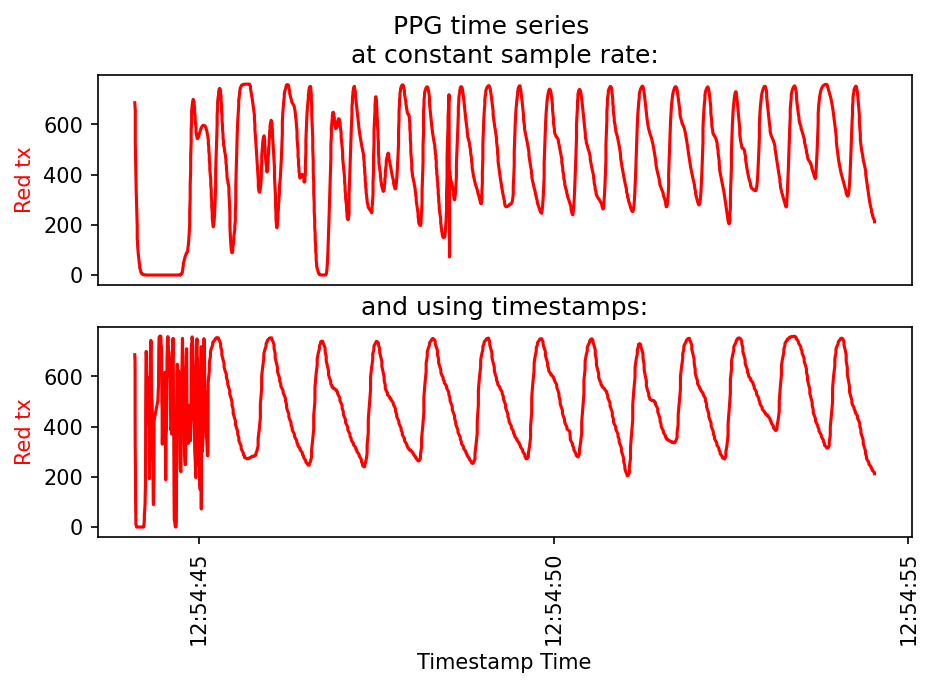

In [19]:
compare_t_axes(ppg)

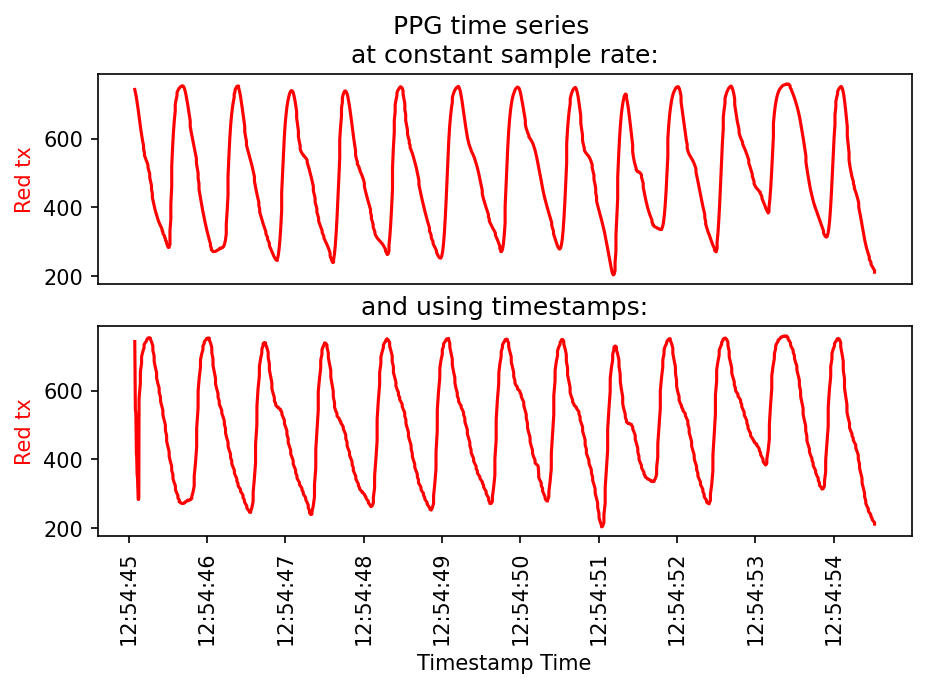

In [20]:
compare_t_axes(ppg[1000:])

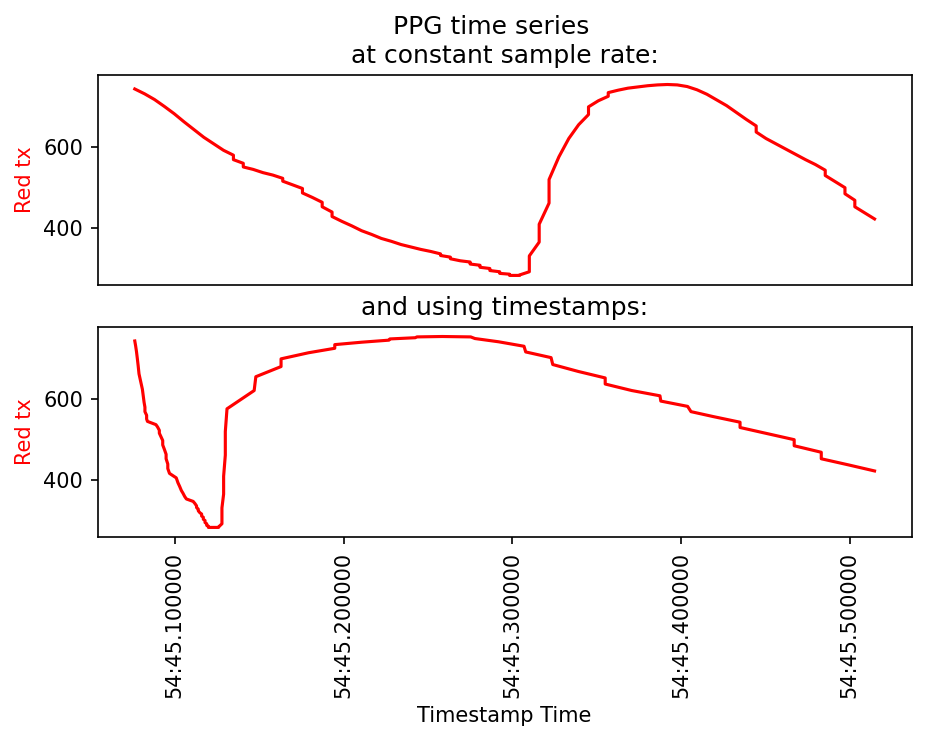

In [21]:
compare_t_axes(ppg[1000:1100])

In [22]:
nRowsRead = 2000 # specify 'None' if want to read whole file
# gamer1-ppg-2000-01-02.csv has 3,177,175 rows (approx 12hrs) in reality,
# but we are only loading/previewing the first 2000 rows
ppg2 = pd.read_csv('./input/' + gamerID + '-ppg-2000-01-02.csv', delimiter=',', nrows = nRowsRead)
ppg2.dataframeName = gamerID + '-ppg-2000-01-02.csv'
ppg2['timestamp'] = pd.to_datetime(ppg2['Time'])
ppg2.head(20)

,Time,Red_Signal,timestamp
0,00:06:19.449082,671,2024-02-02 00:06:19.449082
1,00:06:19.449082,537,2024-02-02 00:06:19.449082
2,00:06:19.449082,430,2024-02-02 00:06:19.449082
3,00:06:19.450071,334,2024-02-02 00:06:19.450071
4,00:06:19.450071,256,2024-02-02 00:06:19.450071
5,00:06:19.450071,196,2024-02-02 00:06:19.450071
6,00:06:19.450071,151,2024-02-02 00:06:19.450071
7,00:06:19.450071,115,2024-02-02 00:06:19.450071
8,00:06:19.451073,89,2024-02-02 00:06:19.451073
9,00:06:19.451073,68,2024-02-02 00:06:19.451073


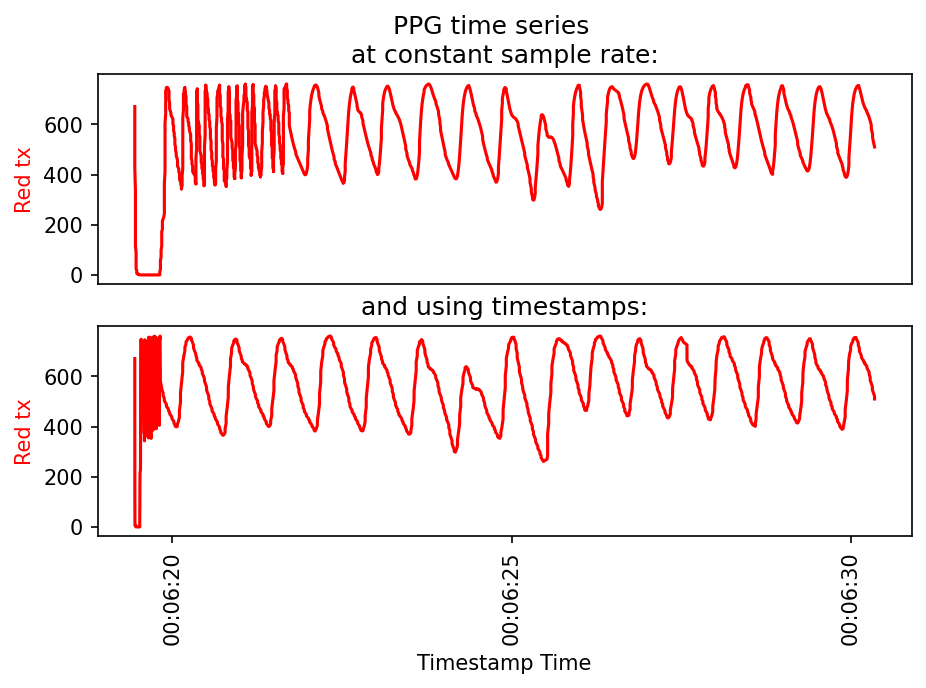

In [23]:
compare_t_axes(ppg2)

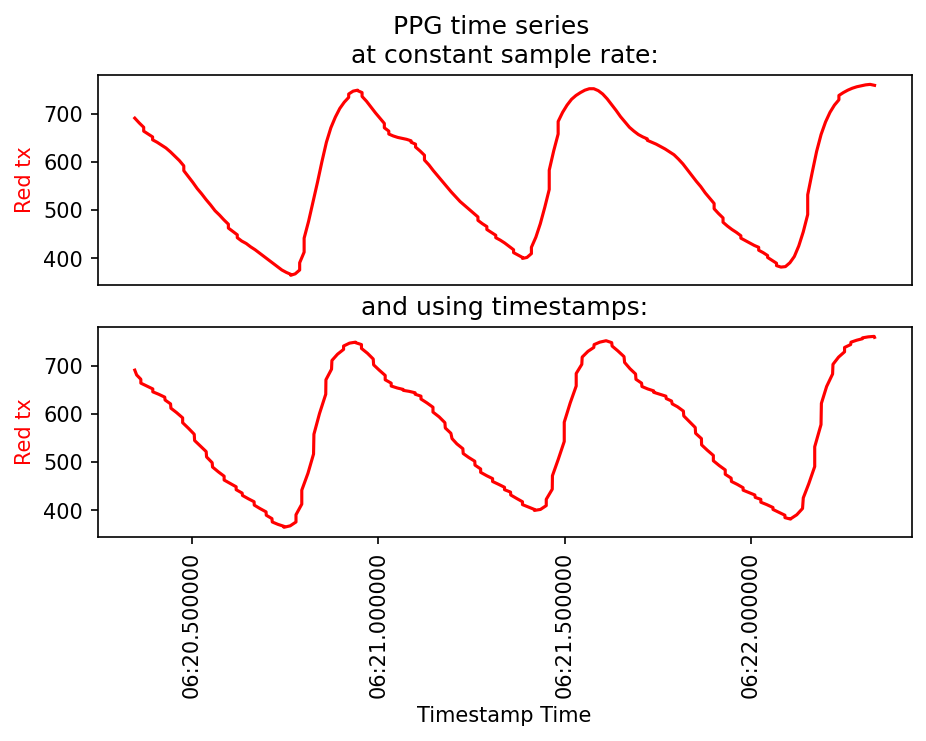

In [24]:
compare_t_axes(ppg2[1000:1200])

In [25]:
ppg2[1000:1200]

,Time,Red_Signal,timestamp
1000,00:06:20.346724,691,2024-02-02 00:06:20.346724
1001,00:06:20.351724,681,2024-02-02 00:06:20.351724
1002,00:06:20.362999,672,2024-02-02 00:06:20.362999
1003,00:06:20.362999,664,2024-02-02 00:06:20.362999
1004,00:06:20.378983,658,2024-02-02 00:06:20.378983
...,...,...,...
1195,00:06:22.298499,756,2024-02-02 00:06:22.298499
1196,00:06:22.299504,758,2024-02-02 00:06:22.299504
1197,00:06:22.314540,760,2024-02-02 00:06:22.314540
1198,00:06:22.330587,761,2024-02-02 00:06:22.330587


In [26]:
ppg3 = ppg2[1000:1200]

In [28]:
ppg3['Red_Signal'].diff()

1000     NaN
1001   -10.0
1002    -9.0
1003    -8.0
1004    -6.0
        ... 
1195     3.0
1196     2.0
1197     2.0
1198     1.0
1199    -2.0
Name: Red_Signal, Length: 200, dtype: float64

<Axes: >

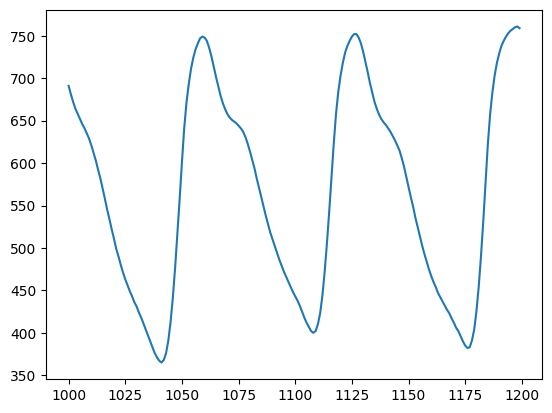

In [32]:
ppg3['Red_Signal'].plot()

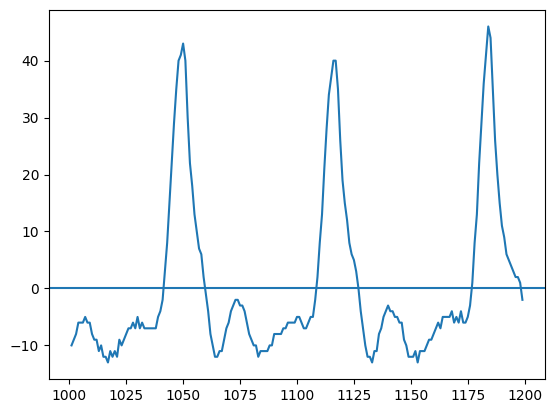

In [31]:
ppg3['Red_Signal'].diff().plot()
plt.axhline(y=0)
# ppg3['Red_Signal'].plot()

In [33]:
y = ppg3['Red_Signal'].diff().values

In [36]:
np.where((y[:-1]>=0) & (y[1:]<=0))

(array([ 59, 126, 127, 198]),)

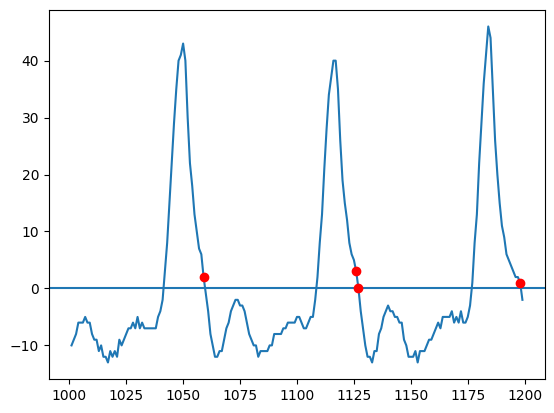

In [43]:
ppg3['Red_Signal'].diff().plot()
plt.axhline(y=0)
peak = ppg3['Red_Signal'].diff().loc[[1059,1126,1127,1198]]
plt.plot(peak.index,peak,'ro')


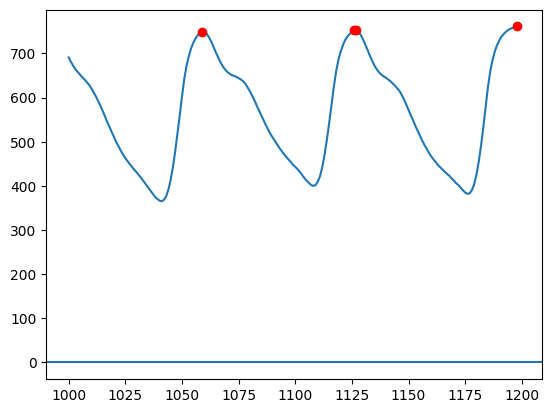

In [44]:
ppg3['Red_Signal'].plot()
plt.axhline(y=0)
peak = ppg3['Red_Signal'].loc[[1059,1126,1127,1198]]
plt.plot(peak.index,peak,'ro')
